In [13]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
%matplotlib inline

# 0. Functions

In [2]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [3]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'2.8% Median: {med1} \n Stats: {stat1} \n')
    print(f'5.6% Median: {med2} \n Stats: {stat2} \n')
    print(f'8.4% Median: {med3} \n Stats: {stat3} \n')
    print(f'11.2% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    return meds, maxs

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    #print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    #print(f'AGR Median: {medagr} \n Stats: {statagr} \n')
    #print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    #print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    return meds, maxs

In [4]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 10000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [6]:
pklfile = '../../prep-pkls/nucmoles_mlecompare_sep2019/bigger-mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)

## (a) Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [7]:
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
ratios = XY.loc[:, lbls].copy()

In [8]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)

## (b) Get test sample for LL calcs

In [10]:
ratios.sample(15)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
56378,pwr,2476.505799,2.950,4233.15,ce14x14,0.797468,1.851190e-03,0.298710,0.002730,12.216953,6.099585,0.036826,0.090621,1.483373e-02,7.952422e-04
90732,agr,2557.296554,4.360,6105.84,agr,0.790889,2.196391e-03,0.587786,0.004610,25.242326,12.600969,0.043416,0.172642,3.754132e-02,3.779558e-03
3945,pwr,902.251192,3.080,760.01,ce14x14,0.873523,6.773547e-04,0.284870,0.001133,1.589831,0.820339,0.009994,0.015468,5.417625e-04,3.783251e-06
26863,pwr,1573.317413,2.880,1879.71,ce14x14,0.839979,1.464557e-03,0.282068,0.001680,5.125478,2.400637,0.023011,0.043194,3.630120e-03,7.505519e-05
80001,pwr,3829.234735,3.200,5545.66,ce14x14,0.735472,8.009877e-04,0.330288,0.003616,15.832866,7.924846,0.033851,0.113142,2.045455e-02,1.740119e-03
67098,agr,3277.938036,3.770,5017.30,agr,0.753498,9.389920e-04,0.605217,0.003820,22.130282,10.933099,0.031742,0.148923,2.361954e-02,2.116201e-03
322,pwr,630.378838,3.080,1.09,ce14x14,0.885957,8.017802e-07,1.097569,0.000812,0.000031,0.279015,0.000001,0.000002,3.903509e-11,2.925073e-16
37205,agr,1206.177077,4.020,2257.12,agr,0.856366,2.638627e-03,0.532189,0.002337,9.069565,4.020000,0.028489,0.071875,7.378178e-03,2.141155e-04
15359,agr,616.208326,4.110,1338.84,agr,0.889192,2.417619e-03,0.512127,0.001662,5.076508,2.155716,0.020403,0.042922,2.798354e-03,4.288066e-05
56426,pwr,2656.418831,2.950,4233.15,ce14x14,0.788370,1.587556e-03,0.302158,0.002730,12.216953,6.099585,0.035383,0.090621,1.448499e-02,7.952422e-04


In [11]:
# Choosing PHWR sample intentionally
sim_idx = 45512
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
45512,phwr,1957.77092,0.711,2191.35,candu37


## (c) LL calcs for uncertainty = 2.8%, 5.6%, 8.4%, 11.2%

In [12]:
fullXY = ratios.loc[ratios['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [11]:
uncs = [0.028, 0.056, 0.084, 0.112]
for unc in uncs:
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

## (d) Half trainset + full trainset

In [12]:
trainXY = fullXY.sample(frac=0.5)

# 2. LogLikelihood for 3 reactors with Uncertainty = 11%

In [13]:
ll = 'LogLikelihood_0.112'
zname = [ll, ll, ll, ll]
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']

## (a) Half trainset

In [14]:
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll)
plotXY1 = trainXY_pwr.loc[trainXY_pwr[ll] > meds[0]]
plotXY2 = trainXY_agr.loc[trainXY_agr[ll] > meds[1]]
plotXY3 = trainXY_phwr.loc[trainXY_phwr[ll] > meds[2]]
plotXY4 = trainXY.loc[trainXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


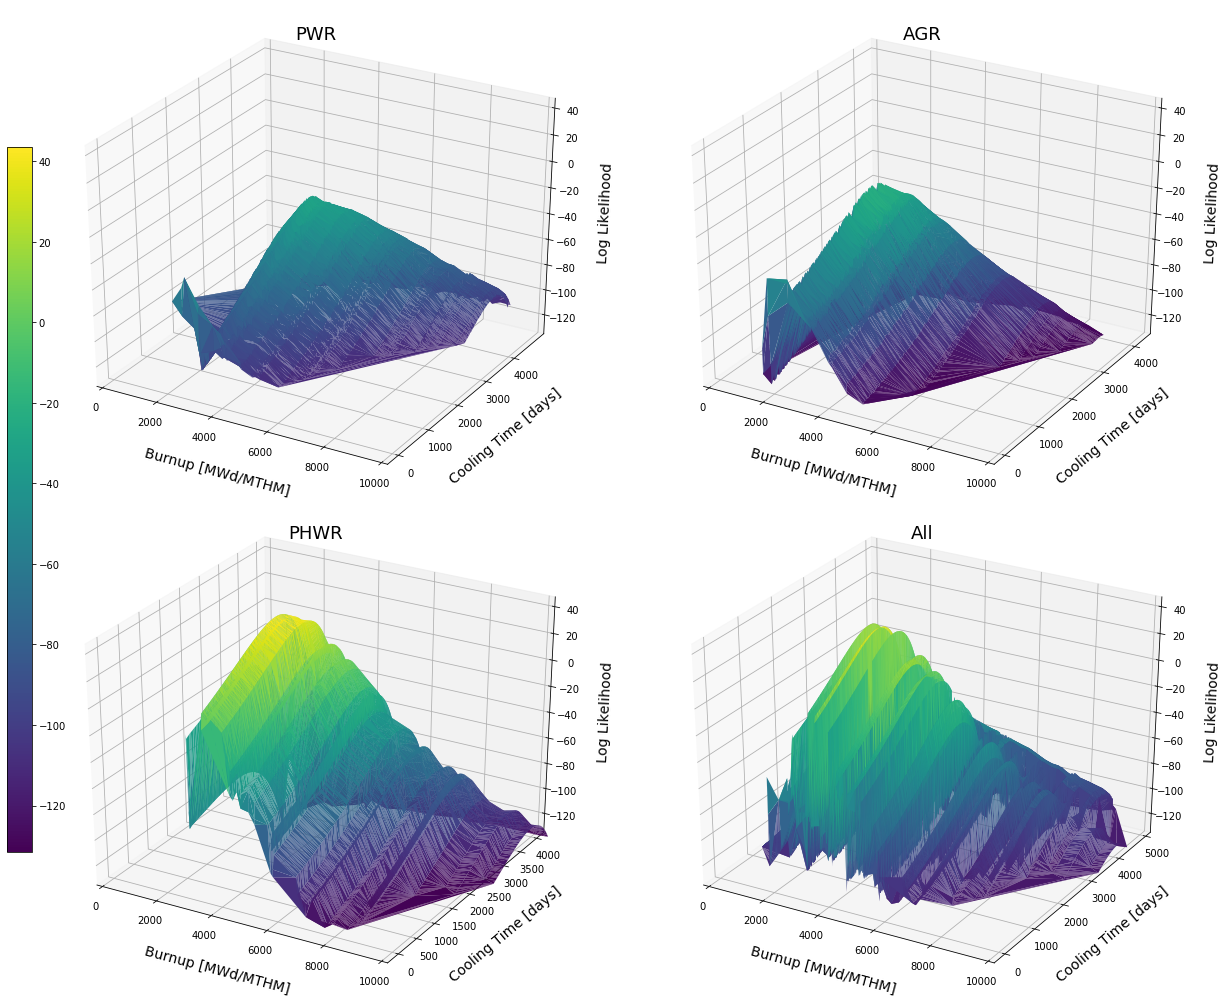

In [15]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

## (b) Full trainset

In [16]:
fullXY_pwr = fullXY.loc[fullXY['ReactorType'] == 'pwr'].copy()
fullXY_agr = fullXY.loc[fullXY['ReactorType'] == 'agr'].copy()
fullXY_phwr = fullXY.loc[fullXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(fullXY_pwr, fullXY_agr, fullXY_phwr, fullXY, ll)
plotXY1 = fullXY_pwr.loc[fullXY_pwr[ll] > meds[0]]
plotXY2 = fullXY_agr.loc[fullXY_agr[ll] > meds[1]]
plotXY3 = fullXY_phwr.loc[fullXY_phwr[ll] > meds[2]]
plotXY4 = fullXY.loc[fullXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


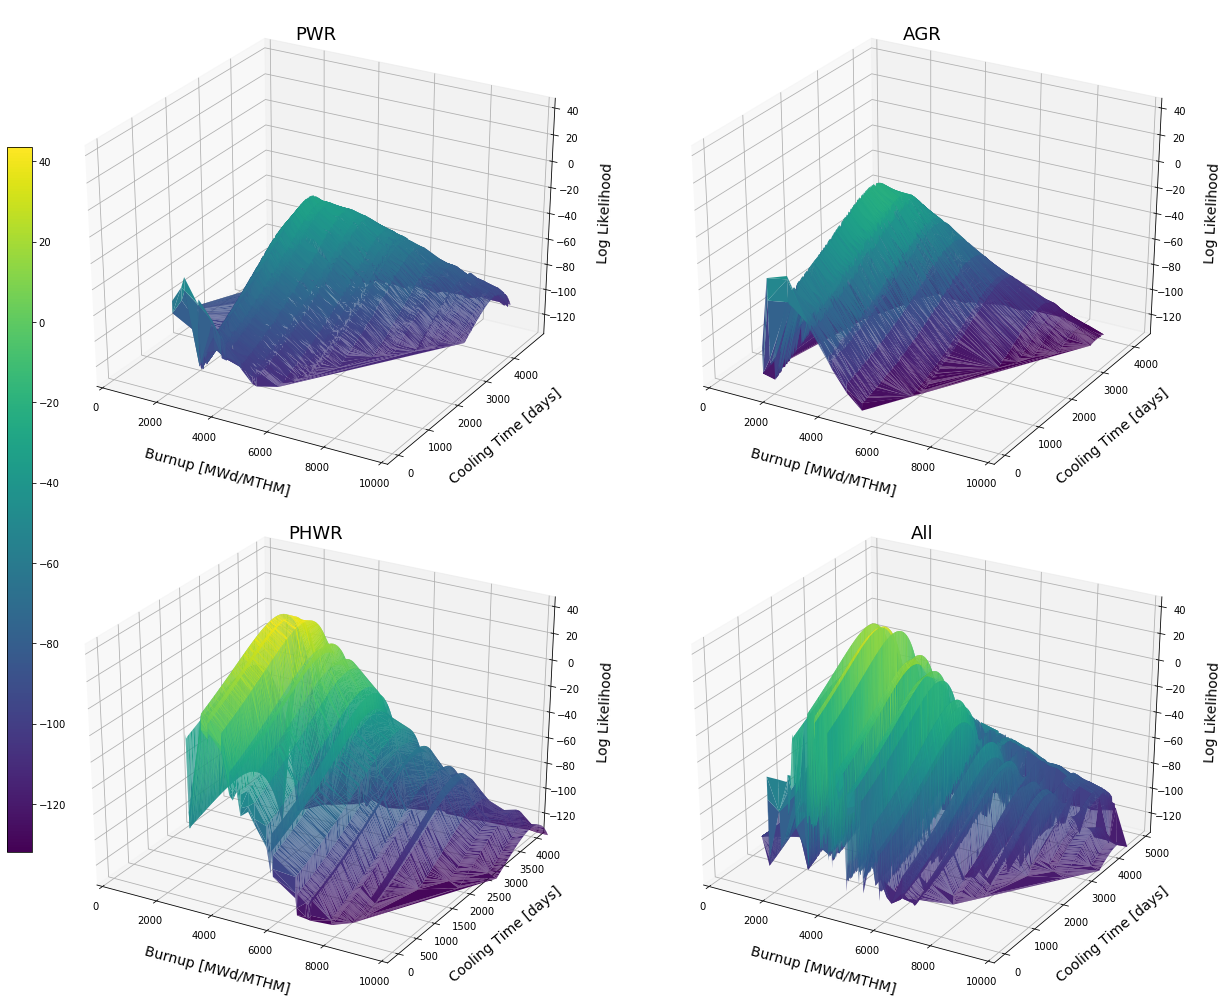

In [17]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

# 3. LogLikelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [18]:
ll1 = 'LogLikelihood_0.028'
ll2 = 'LogLikelihood_0.056'
ll3 = 'LogLikelihood_0.084'
ll4 = 'LogLikelihood_0.112'
zname = [ll1, ll2, ll3, ll4]
uncss = ['2.8% Unc', '5.6% Unc', '8.4% Unc', '11.2% Unc']

## (a) Half trainset

In [19]:
meds, maxs = getstats_unc(trainXY, ll1, ll2, ll3, ll4)

2.8% Median: -2429.1129688838564 
 Stats: DescribeResult(nobs=36573, minmax=(-786506914.9065645, 57.450589338695494), mean=-5070520.949950079, variance=2052609096085233.5, skewness=-9.725669277950127, kurtosis=97.99980645552601) 

5.6% Median: -578.3678471754423 
 Stats: DescribeResult(nobs=36573, minmax=(-196626670.64984477, 50.521789914905646), mean=-1267596.9314169458, variance=128288015637978.81, skewness=-9.725669764084413, kurtosis=97.99981671976063) 

8.4% Median: -238.05869573812936 
 Stats: DescribeResult(nobs=36573, minmax=(-87389591.15112701, 46.46763371934429), mean=-563354.5138448903, variance=25340825190298.633, skewness=-9.72567057429385, kurtosis=97.99983382662745) 

11.2% Median: -120.77815402407282 
 Stats: DescribeResult(nobs=36573, minmax=(-49156614.78426867, 43.5992616241531), mean=-316871.1253875168, variance=8017987760580.242, skewness=-9.725671708556897, kurtosis=97.99985777584047) 



In [27]:
cutoff = -1200

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


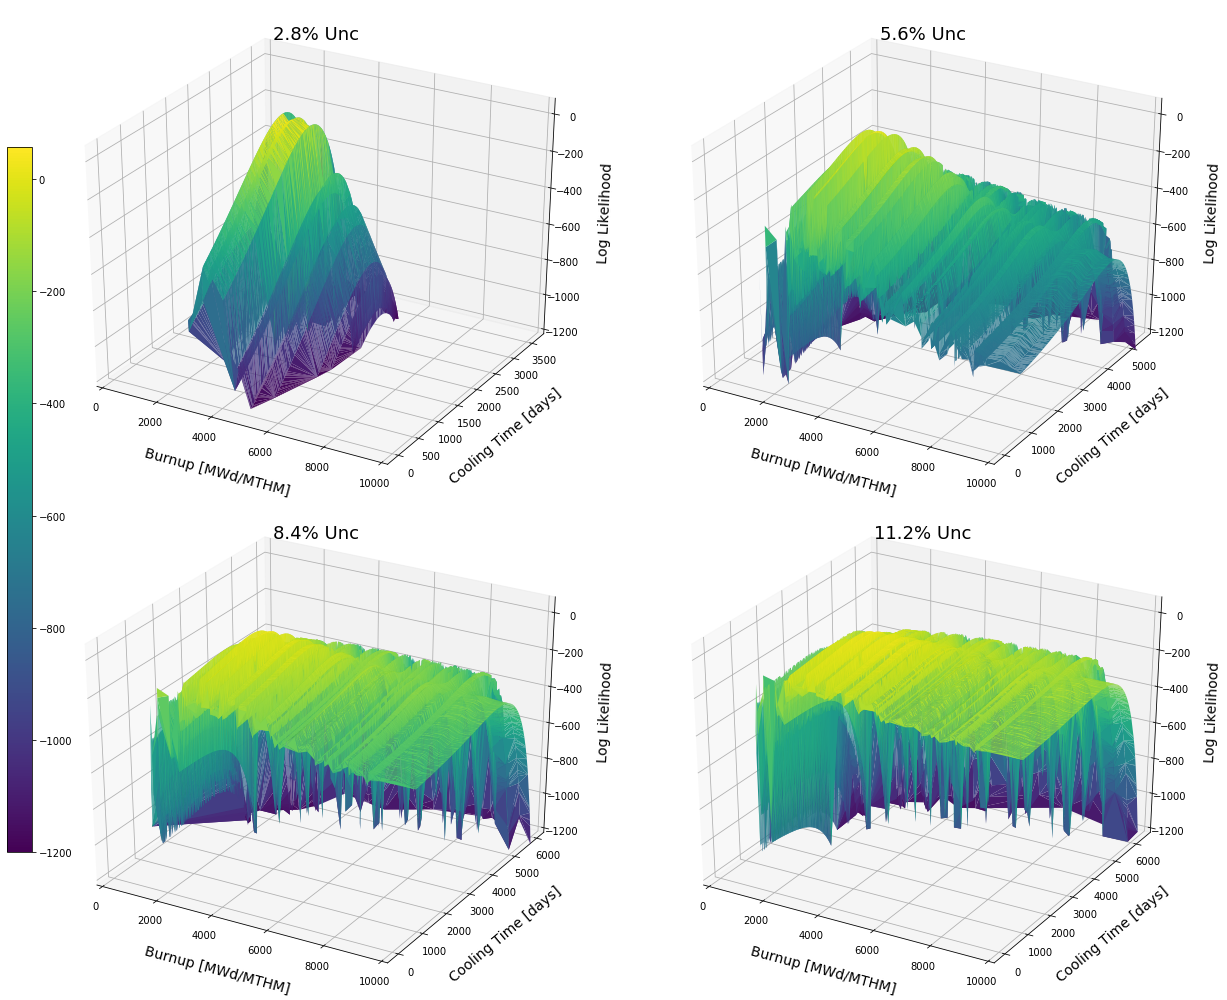

In [28]:
plotXY1 = trainXY.loc[trainXY[ll1] > cutoff]
plotXY2 = trainXY.loc[trainXY[ll2] > cutoff]
plotXY3 = trainXY.loc[trainXY[ll3] > cutoff]
plotXY4 = trainXY.loc[trainXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))

## (b) Full trainset

In [29]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)

2.8% Median: -2417.885353193109 
 Stats: DescribeResult(nobs=73146, minmax=(-786506914.9065645, 57.45131447752493), mean=-5219401.396430869, variance=2117677796567962.5, skewness=-9.601146331306941, kurtosis=95.59589432596316) 

5.6% Median: -575.698298546115 
 Stats: DescribeResult(nobs=73146, minmax=(-196626670.64984477, 50.521789914905646), mean=-1304817.0777492167, variance=132354807603821.81, skewness=-9.6011468150856, kurtosis=95.5959044497773) 

8.4% Median: -237.148438731981 
 Stats: DescribeResult(nobs=73146, minmax=(-87389591.15112701, 46.46763371934429), mean=-579896.8268163238, variance=26144141524513.652, skewness=-9.601147621369766, kurtosis=95.59592132262263) 

11.2% Median: -120.16294101927173 
 Stats: DescribeResult(nobs=73146, minmax=(-49156614.78426867, 43.5992616241531), mean=-326176.19668265776, variance=8272161804863.473, skewness=-9.601148750139041, kurtosis=95.595944944232) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


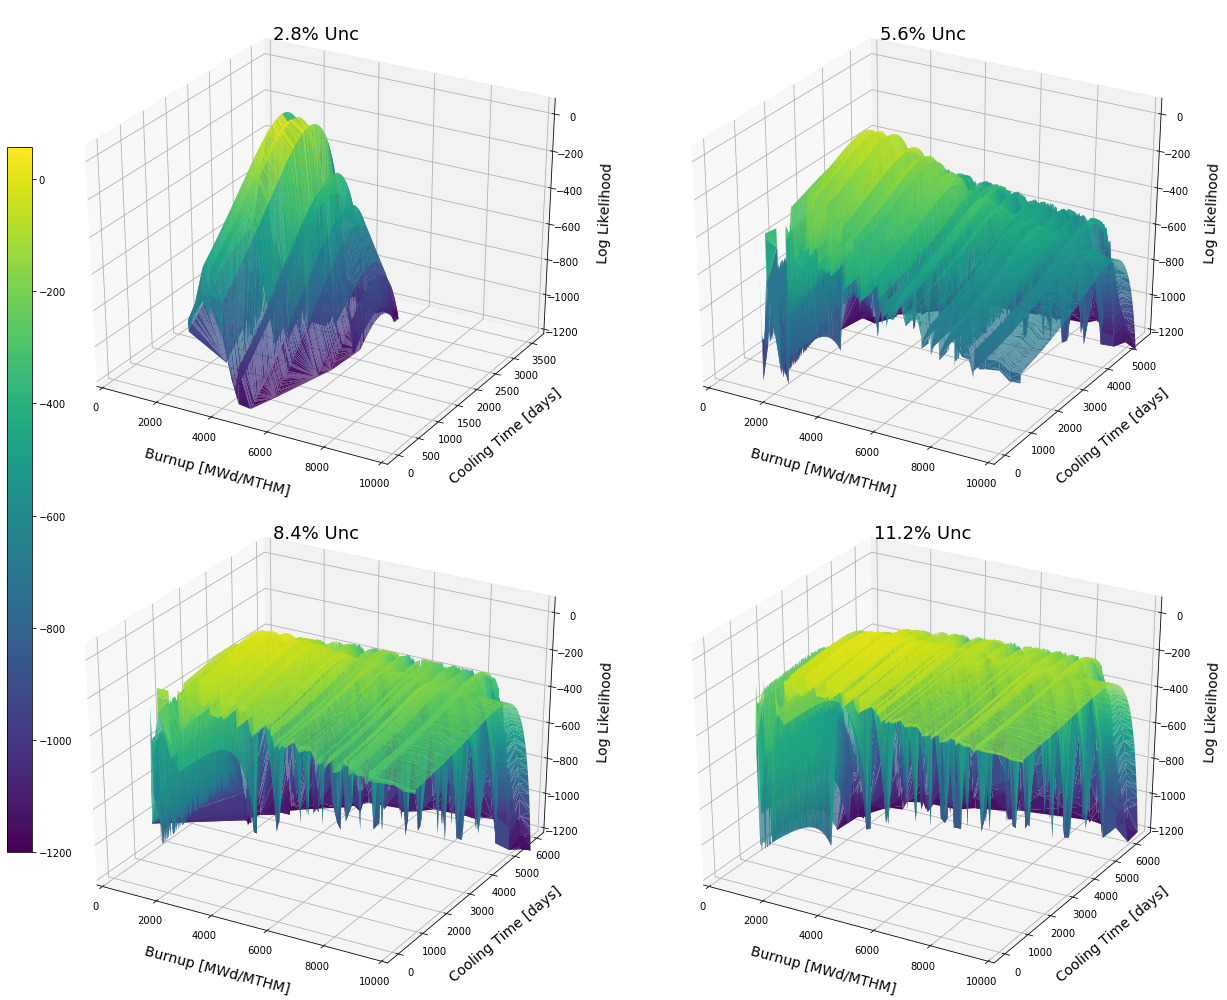

In [30]:
plotXY1 = fullXY.loc[fullXY[ll1] > cutoff]
plotXY2 = fullXY.loc[fullXY[ll2] > cutoff]
plotXY3 = fullXY.loc[fullXY[ll3] > cutoff]
plotXY4 = fullXY.loc[fullXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))